# Feedback

## Load Modules

In [2]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
print("file_dir: -> ",file_dir)

parent_dir = file_dir.parent
print(parent_dir)

sys.path.append(str(parent_dir))

file_dir: ->  C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython\vkprog_analyse
C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython


In [3]:
%load_ext autoreload
%autoreload
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pa_lib.data import (
    clean_up_categoricals
    )

from pa_lib.vis import (
    boxplot_histogram,
    )

from pa_lib.file import (
    project_dir,
    load_bin,
    load_csv,
    load_xlsx
    )
from pa_lib.util import (
    cap_words
    )                 
import os,fnmatch

https://stackabuse.com/python-list-files-in-a-directory/

# Load Data (Feedback)

In [4]:
def load_feedback(sales_folder):
    sales_subfolder = os.listdir(sales_folder)
    pattern = "EK_LIST*.xlsx"
    
    container_df = pd.DataFrame()
    columns_in_xlsx = ["Gepard-Nr. Endkunde","Endkunde", "Chance","Feedback - bitte auswählen", "falls nicht hilfreich, bitte hier einen kurzen Kommentar angeben - entweder pro Zeile oder für die Gesamt-Liste" ]
    rename_columns = ["Endkunde_NR", "Endkunde", "Prob_1","Feedback", "Kommentar"]

    
    for kw_folder in sales_subfolder:

        if kw_folder >= "2019_07_15": # Begin of automatisation

            all_files_list = os.listdir(sales_folder / kw_folder)

            for file in all_files_list:

                if fnmatch.fnmatch(file, pattern):
                    #print(f"{kw_folder}  ---- {file}") # Check!
                    vkber_df = (
                        load_xlsx(
                            sales_folder / kw_folder / file
                            )
                        .loc[:,columns_in_xlsx]
                        )#.iloc[:,[0,1,-3,-2,-1]])
                    
                    vkber_df.columns = rename_columns

                    vkber_df.loc[:,"folder"] = kw_folder
                    vkber_df.loc[:,"file_name"] = file

                    container_df = (
                        container_df.append(vkber_df,ignore_index=False)
                        )
    
    container_df.loc[:,"Kuerzel"] = container_df.loc[:,"file_name"].apply(lambda x: x[19:22])
    
    #Remove all redundant rows:
    feedback_exists = (
        (   # Feedback or Kommentar exists
            ~container_df.loc[:, "Feedback"].isna() |
            ~container_df.loc[:,"Kommentar"].isna()
            ) & # Endkunde_NR must exist
            ~container_df.loc[:,"Endkunde_NR"].isna()
        )
    
    
    
    return container_df.loc[feedback_exists,:].sort_values(["folder","file_name"], ascending=[False,True])

In [5]:
sales_folder = Path('P:\Service\Kennzahlen\Verkauf\PredictiveAnalytics')
print(sales_folder)

P:\Service\Kennzahlen\Verkauf\PredictiveAnalytics


In [6]:
%%capture
raw_feedback = load_feedback(sales_folder=sales_folder)

# Feedback Count

In [7]:
print(f"shape: {raw_feedback.shape}")

shape: (744, 8)


In [8]:
min(raw_feedback.shape[0], 3000)

744

In [9]:
import pandas as pd
pd.set_option('display.max_rows', min(raw_feedback.shape[0]+1 ,3000))
pd.set_option("display.max_colwidth",500)

In [10]:
raw_feedback.sample(5)

,Endkunde_NR,Endkunde,Prob_1,Feedback,Kommentar,folder,file_name,Kuerzel
3,117648,Centre Social Protestant Vaud,11.5,hilfreich,Relance promotion PME semaines 50 -4 2020,2019_11_04,EK_LIST_2W_KOMPAKT_MZB.xlsx,MZB
6,628168,Fondazione Ticino Cuore,4.0,NaN,Già nella lista precedente,2019_10_07,EK_LIST_2W_KOMPAKT_LPA.xlsx,LPA
6,113679,Hotel Suvretta House,6.4,hilfreich,Buchungen kommen wieder für 2020,2019_09_23,EK_LIST_2W_KOMPAKT_BON.xlsx,BON
15,134076,Anluc SA,1.2,hilfreich,NaN,2019_07_15,EK_LIST_2W_KOMPAKT_LPA.xlsx,LPA
13,616554,Radio TV Hofmann,2.2,nicht hilfreich,nächstens in Pension,2019_11_04,EK_LIST_2W_KOMPAKT_CFU.xlsx,CFU


# Teilnahme

In [11]:
(
raw_feedback
    .groupby("folder")
    .agg({"Endkunde_NR": "count"})
    
)

,Endkunde_NR
folder,
2019_07_15,106
2019_09_23,111
2019_10_07,120
2019_10_21,106
2019_11_04,141
2019_11_18,160


Text(0, 0.5, 'Anzahl')

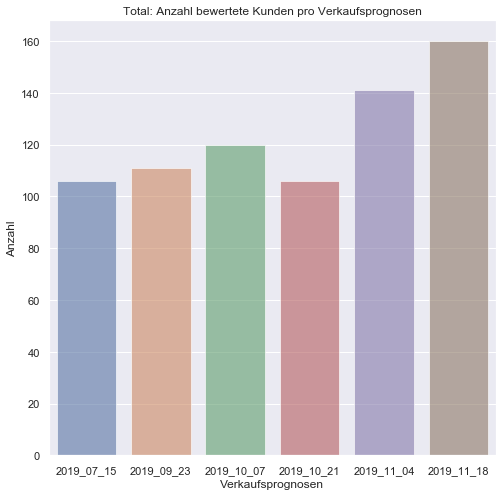

In [12]:
sns.set(style="darkgrid")
plt.figure(figsize=(8,8))
ax = (
    sns.countplot(
        x     = "folder",
        #y    = "Feedback",
        data  = raw_feedback,
        alpha = 0.6,
        #order = raw_feedback.loc[:,'Kuerzel'].value_counts().index
        )
    )

plt.title("Total: Anzahl bewertete Kunden pro Verkaufsprognosen")
plt.xlabel("Verkaufsprognosen")
plt.ylabel("Anzahl")

## Insights

***
>1. Die Teilnahme nimmt zu.
2. The Vkber-Lists in the following folders have not been touched (see also timestamps on each xlsx-file):
    * `2019_09_09`
    * `2019_08_26` 
    * `2019_08_12`
    * [`2019_07_29`](P:\Service\Kennzahlen\Verkauf\PredictiveAnalytics\2019_07_29)
***

## Top participants

In [13]:
(
raw_feedback
    .groupby("Kuerzel")
    .agg({"Endkunde": "count"})
    .sort_values("Endkunde",ascending=False)
)

,Endkunde
Kuerzel,
LPA,116
BON,100
TRA,61
JAN,59
CGA,49
ACO,39
ROK,32
MBU,27
MZB,25


Text(0, 0.5, 'Anzahl')

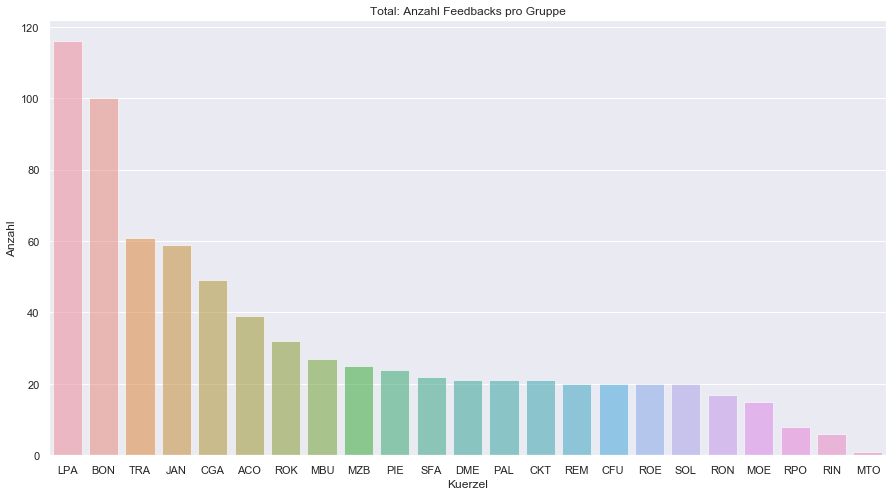

In [14]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
ax = (
    sns.countplot(
        x     = "Kuerzel",
        #y    = "Feedback",
        data  = raw_feedback,
        alpha = 0.6,
        order = raw_feedback.loc[:,'Kuerzel'].value_counts().index
        )
    )
    
plt.title("Total: Anzahl Feedbacks pro Gruppe")
plt.xlabel("Kuerzel")
plt.ylabel("Anzahl")

Text(84.5, 0.5, 'Kuerzel')

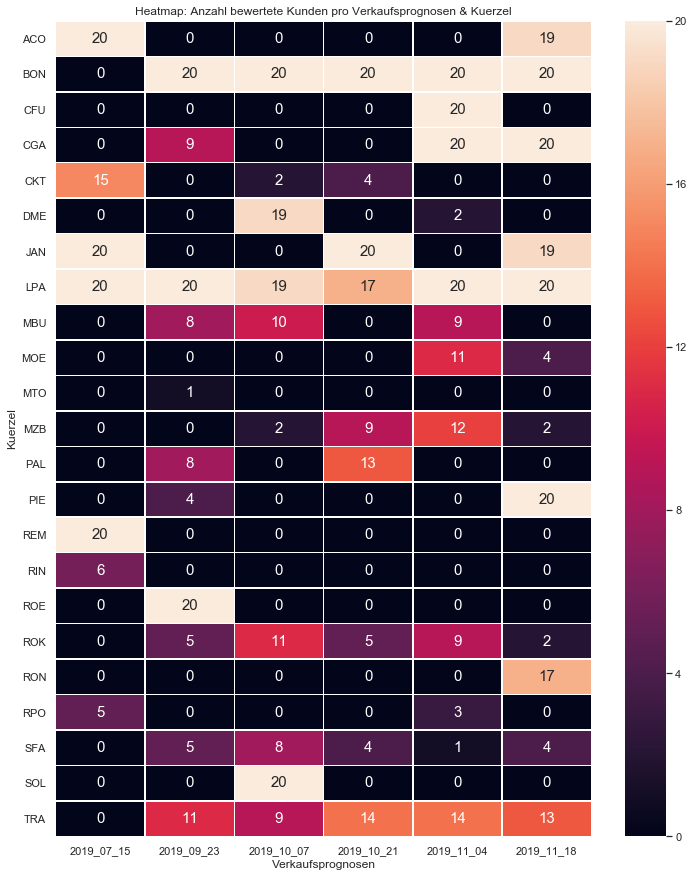

In [15]:
heatmap_data = pd.pivot_table(
    raw_feedback,
    index      = "folder",
    columns    = "Kuerzel",
    values     = "Endkunde_NR",
    aggfunc    = np.count_nonzero,
    fill_value = 0
    ).T

plt.figure(figsize=(12,15))

ax = sns.heatmap(
    data       = heatmap_data,
    linewidths = 0.5,
    annot      = True,
    annot_kws={"size": 15},
    )

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title("Heatmap: Anzahl bewertete Kunden pro Verkaufsprognosen & Kuerzel")
plt.xlabel("Verkaufsprognosen")
plt.ylabel("Kuerzel")

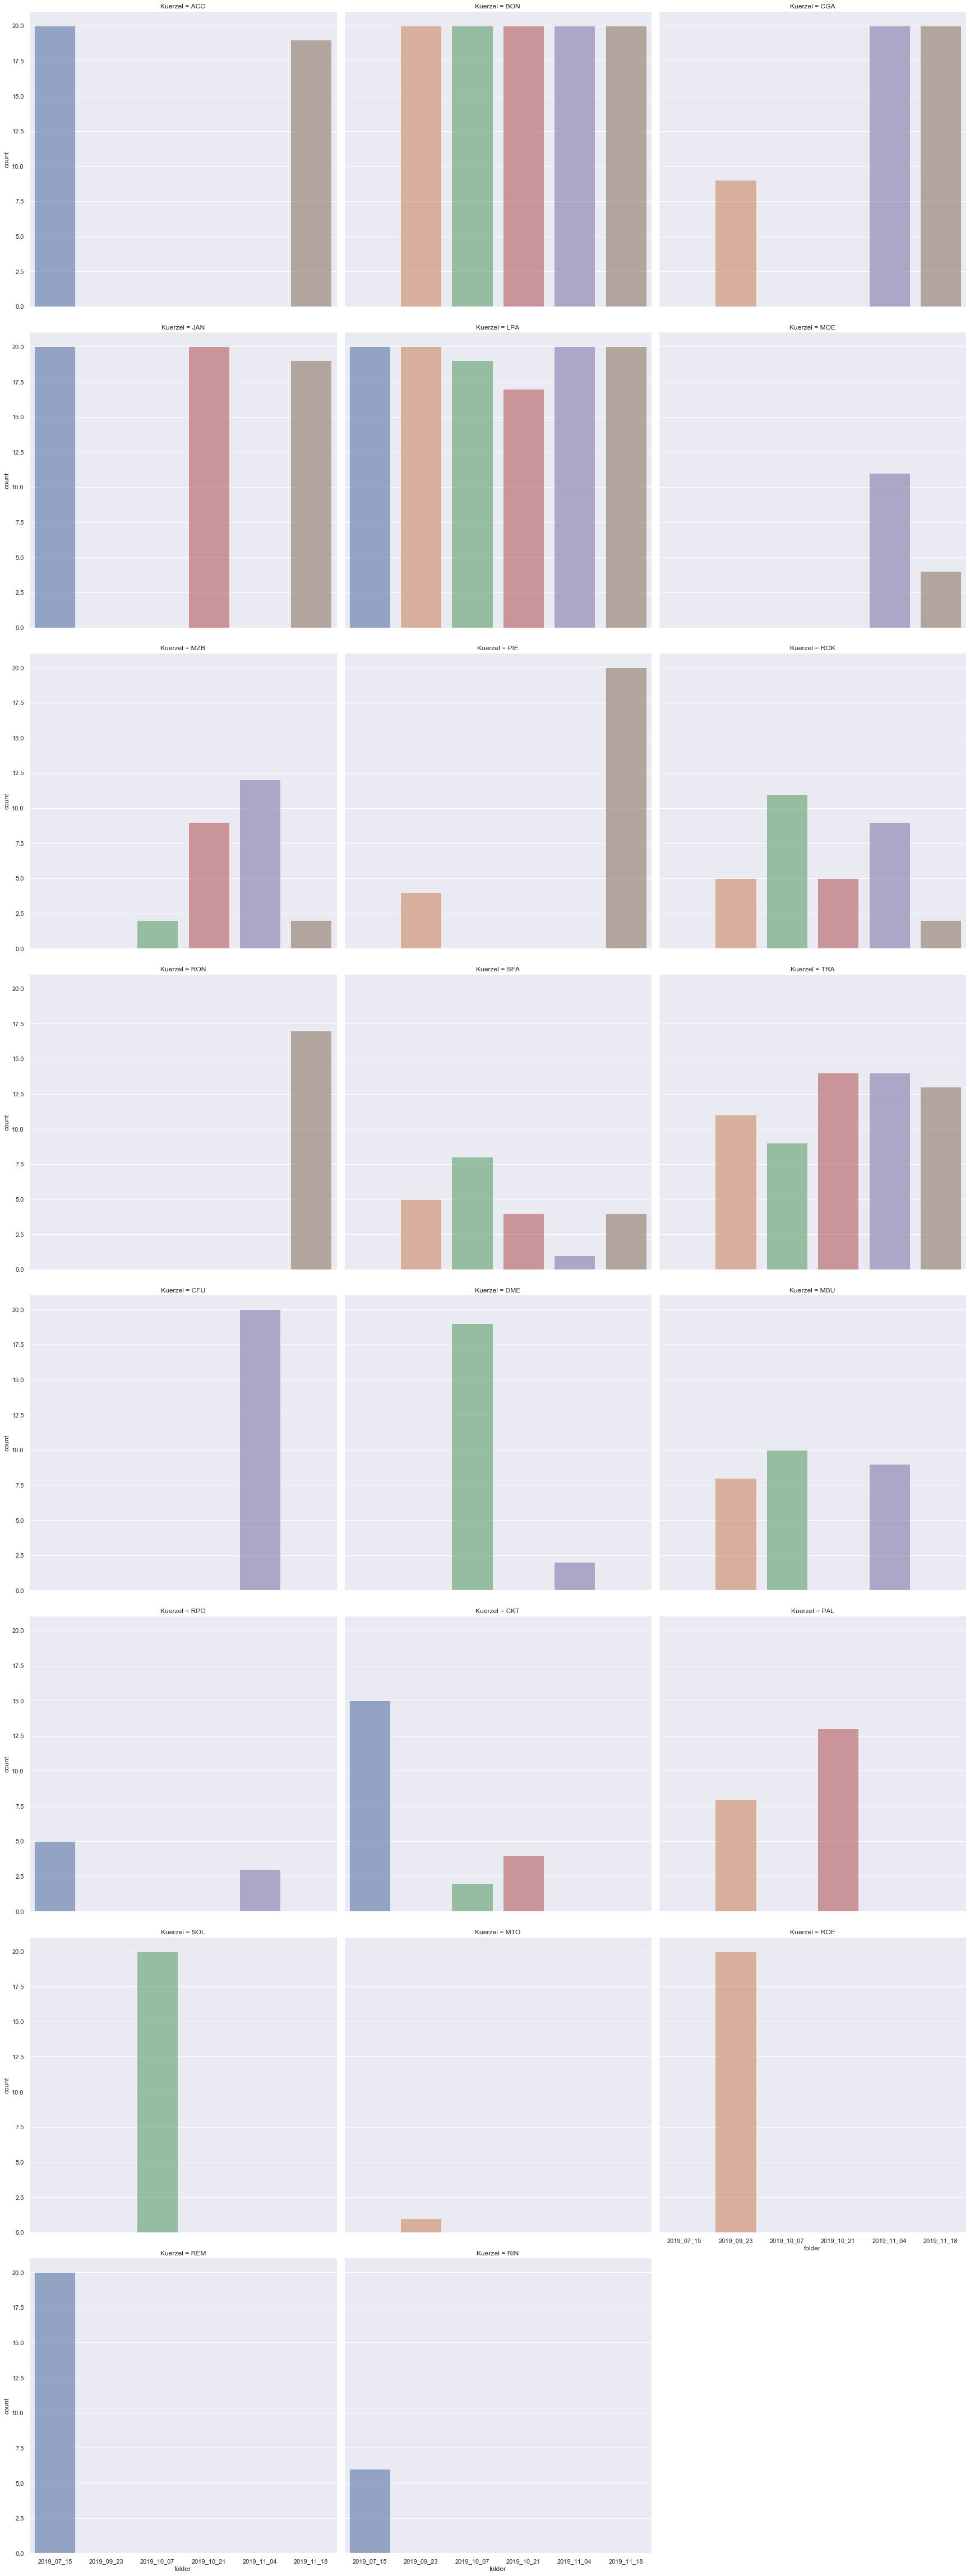

In [16]:
g = (
    sns.catplot(
        x="folder",
        #hue="folder",
        col="Kuerzel",
        data=raw_feedback,
        kind="count",
        height=8,
        aspect=1,
        col_wrap=3,
        alpha=0.6,
        )
    )

## Insights

***
>1. Vorsicht: Die Verkaufsberater erhalten jeweils eine unterschiedliche Anzahl Leads.
***

# Feedback so far: helpful? not helpful?

In [17]:
(
raw_feedback
    .groupby("Feedback")
    .agg({"Endkunde": "count"})
    .sort_values("Endkunde",ascending=False)
)

,Endkunde
Feedback,
hilfreich,281
nicht hilfreich,257
nicht bearbeitet,42


Text(0, 0.5, 'Anzahl')

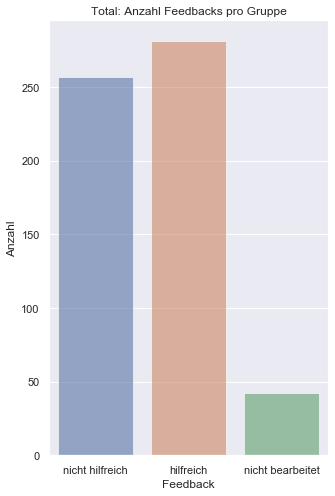

In [18]:
sns.set(style="darkgrid")
plt.figure(figsize=(5,8))
ax = (
    sns.countplot(
        x     = "Feedback",
        #y    = "Feedback",
        data  = raw_feedback,
        alpha = 0.6,
        )
    )
    
plt.title("Total: Anzahl Feedbacks pro Gruppe")

plt.xlabel("Feedback")
plt.ylabel("Anzahl")

Text(0, 0.5, 'Anzahl')

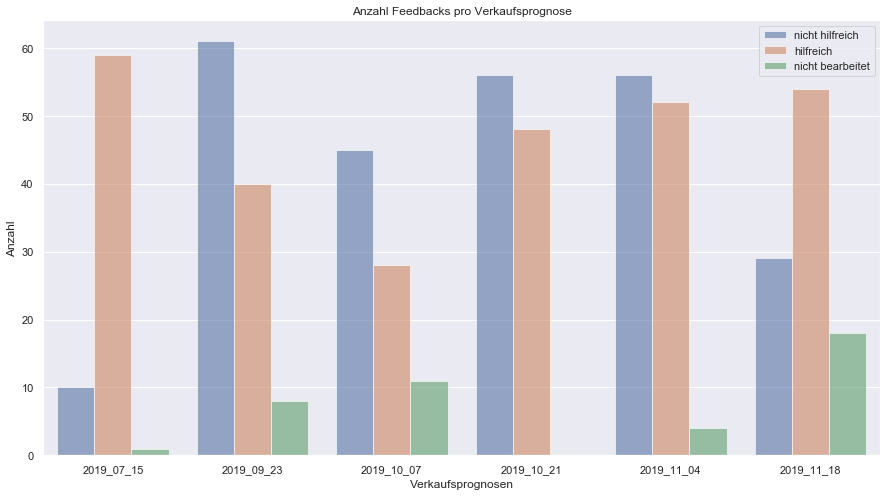

In [23]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
ax = (
    sns.countplot(
        x     = "folder",
        hue   = "Feedback",
        data  = raw_feedback,
        alpha = 0.6,
        )
    )
plt.legend(loc='best')

plt.title("Anzahl Feedbacks pro Verkaufsprognose")
plt.xlabel("Verkaufsprognosen")
plt.ylabel("Anzahl")

## Insights

***
> 1. Seit der Umstellung auf Random Forest `2019_11_18` ist die  Anzahl der `hilfreich` grösser als `nicht hilfreich`
***

# `Kommentar` Felder

## `nicht hilfreich`, `nicht bearbeitet`, `NaN`

In [34]:
not_helpful_rows = (
    ~raw_feedback
        .Feedback
        .isin({"hilfreich"})
    )

interesting_cols = ["Endkunde_NR", "Endkunde", "Prob_1","Feedback","Kommentar", "folder", "Kuerzel"]

not_helpful_df = (
    raw_feedback
        .loc[not_helpful_rows,interesting_cols]
        .sort_values(["folder","Feedback"], ascending=[False,False])
    )

print(f"\nAnzahl Einträge: {not_helpful_df.shape[0]}\n")

display(not_helpful_df)


Anzahl Einträge: 463



,Endkunde_NR,Endkunde,Prob_1,Feedback,Kommentar,folder,Kuerzel
17,545148,KIBAG RE AG,25.108210,nicht hilfreich,anderes Verkaufsgebiet,2019_11_18,ACO
0,114401,Möbel Stocker AG,58.345082,nicht hilfreich,Firma ist aufgelöst und geschlossen.,2019_11_18,BON
4,174982,FDP.Die Liberalen Davos,40.711529,nicht hilfreich,Die politischen bitte immer rausnehmen.,2019_11_18,BON
5,550386,Massiv Sport AG,40.115533,nicht hilfreich,Firma ist aufgelöst und geschlossen.,2019_11_18,BON
6,559695,Verein ART-PUBLIC Chur,39.947720,nicht hilfreich,Anlass ist nicht jedes Jahr,2019_11_18,BON
8,607538,Verein C-23,38.795597,nicht hilfreich,"schwierig, hier sind wir seit längerem dran",2019_11_18,BON
9,468391,Genossenschaft Glarner Krankenversicherung,38.477501,nicht hilfreich,Bucht immer erst 2. Halbjahr und Kontakt im Feb.März,2019_11_18,BON
10,596029,Kantonsschule Sargans,37.286746,nicht hilfreich,"Ist noch nicht so weit, wird Feb. bis Buchung kommt",2019_11_18,BON
12,555512,Verein Wohlklang,35.920939,nicht hilfreich,findet nicht jährlich statt,2019_11_18,BON
19,219272,SP Chur,32.470685,nicht hilfreich,Die politischen bitte immer rausnehmen.,2019_11_18,BON


## Insights

***
> 1. In den einzelnen Listen befinden sind politische Gruppierungen vorhanden. Nicht erwünscht.
2. Einige der Endkunden sind aufgelöst (zb. Insolvenz)
3. Einige Kunden buchen ausschliesslich über Agentur
4. Kunden sind eigentlich bei anderem Verkausberater
5. Einige Kunden haben für einmalige Events bei uns in der Vergangenheit gebucht. Keine Wiederholungen geplant (zb. Jubiläen)
***

## `hilfreich`

In [25]:
helpful_rows = ~not_helpful_rows

In [36]:
print(f"\nAnzahl Eintraege: {raw_feedback.loc[helpful_rows,interesting_cols].shape[0]}\n")

display(raw_feedback.loc[helpful_rows,interesting_cols])


Anzahl Eintraege: 281



,Endkunde_NR,Endkunde,Prob_1,Feedback,Kommentar,folder,Kuerzel
1,640149,Schweizerische Mobiliar,52.455315,hilfreich,Sofort kontakt aufgenommen mit herr schmutz,2019_11_18,BON
2,642120,Imperial Lounge Club GmbH,45.013510,hilfreich,Mail an Hito gemacht für 2020,2019_11_18,BON
3,124916,Hotel Waldhaus,42.424343,hilfreich,"Kontakt mit Kde, noch offen ob etwas kommt",2019_11_18,BON
7,582188,ONAX AG it solutions,39.726583,hilfreich,Aktion nochmals geschickt,2019_11_18,BON
11,606382,Pur.Catering GmbH,37.057535,hilfreich,"Stehen im Kontakt mit Agentur, Budget steht noch nicht",2019_11_18,BON
13,570719,BIKE EXPLORER,35.347227,hilfreich,"Aktion Thema, stehen im kontakt mit agentur",2019_11_18,BON
14,510724,Open Air Lumnezia AG,34.470454,hilfreich,"Stehen im Kontakt mit Agentur, Budget steht noch nicht",2019_11_18,BON
15,620421,oohh! fine fashion GmbH,34.209751,hilfreich,Aktion nochmals geschickt,2019_11_18,BON
16,113679,Hotel Suvretta House,34.108619,hilfreich,Buchungen sind bereits erfolgt,2019_11_18,BON
17,570636,Velocenter Imholz AG,33.417290,hilfreich,Aktion nochmals geschickt,2019_11_18,BON


## Insights

***
> 1. Obwohl vermerkt, dass Kunde kein Interesse hat, wird der Lead als `hilfreich` bewertet?
***